In [6]:
import os

def get_png_files_from_folder(folder_path):
    png_files = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.png'):
            png_files.append(file_name)
    return png_files

folder_path = '/home/joe/ttop/nlp_proj/data/pdf_resumes/CV_Images_EN'
png_files = get_png_files_from_folder(folder_path)

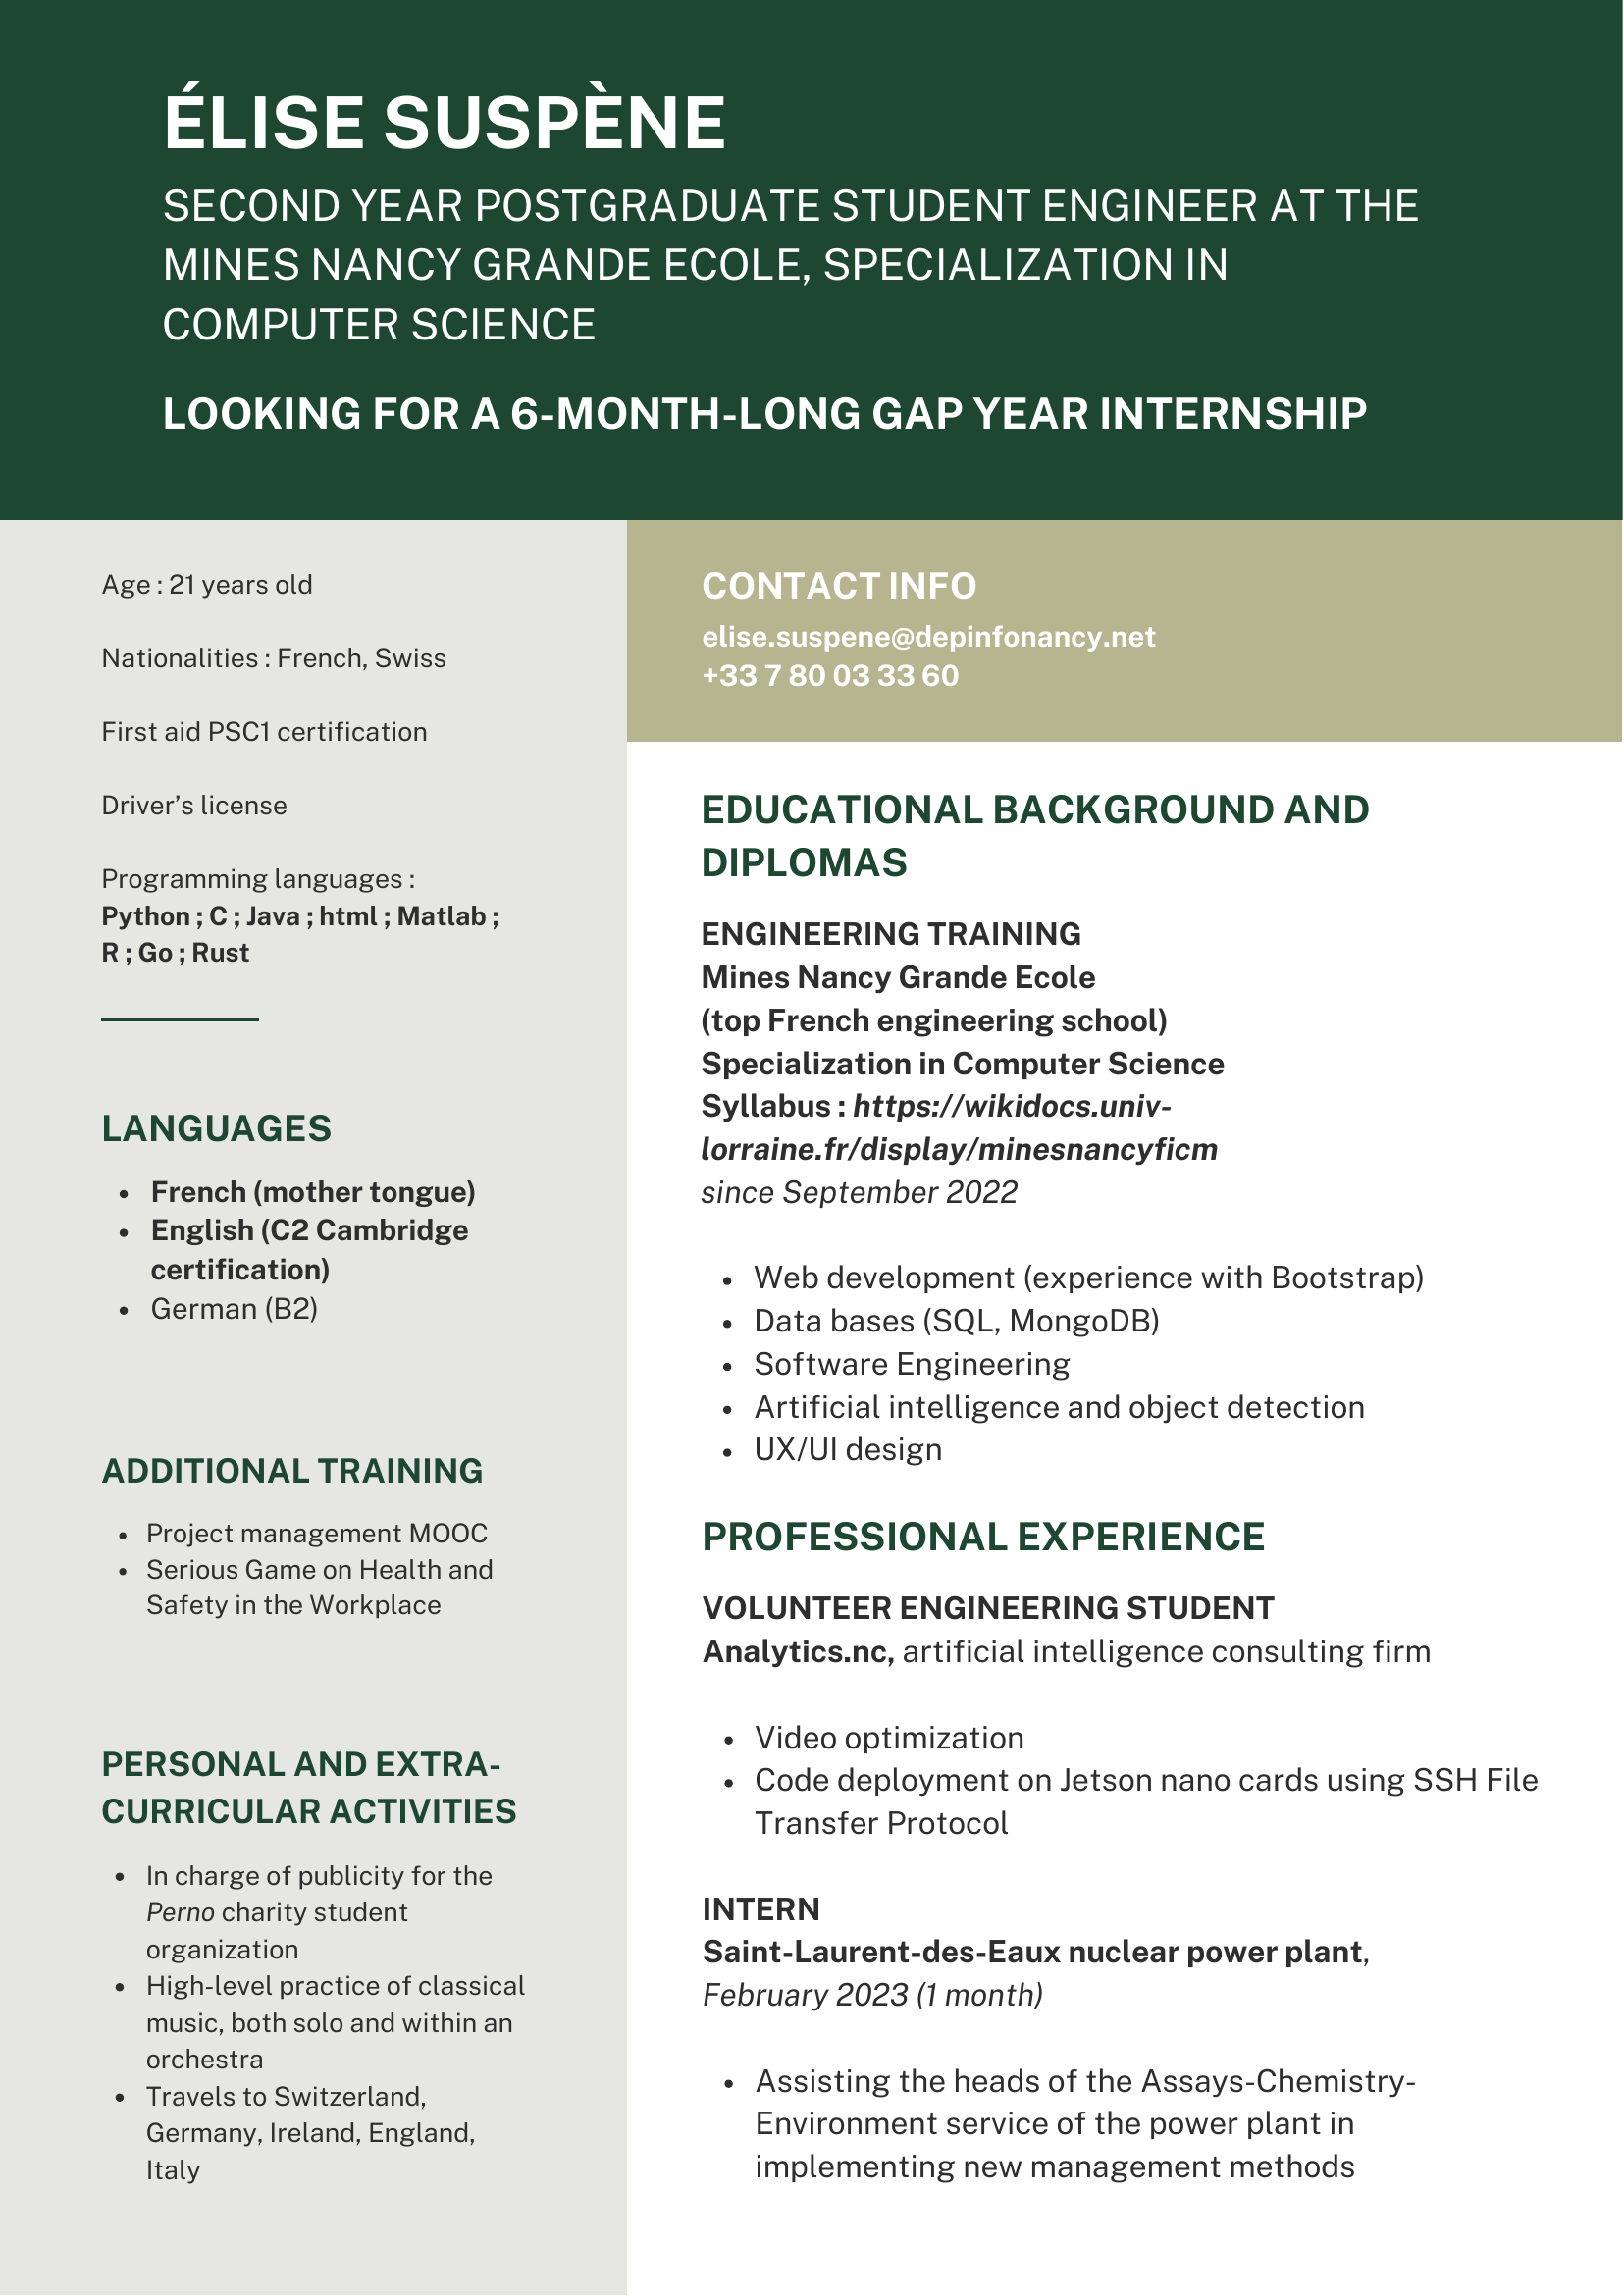

In [7]:
from PIL import Image

images = [Image.open(os.path.join(folder_path, file)).convert("RGB") for file in png_files]
# display the first image in the list
image = images[0]
image.show()

In [8]:
from transformers import TrOCRProcessor

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-large-printed")
# calling the processor is equivalent to calling the feature extractor
pixel_values = processor(image, return_tensors="pt").pixel_values
print(pixel_values.shape)

preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

torch.Size([1, 3, 384, 384])


In [12]:
from transformers import VisionEncoderDecoderModel

model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-large-printed")

config.json:   0%|          | 0.00/4.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.43G [00:00<?, ?B/s]

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 16,
  "num_channels": 3,
  "num_hidden_layers": 24,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.47.0"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 1024,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decod

generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [13]:
generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_text)

TOTAL : 1/1/2018 : 1/1, 1/1


In [15]:
import os
from PIL import Image
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import base64
from io import BytesIO

def create_ocr_pipeline_output(folder_path, output_path):
    """
    Process images in a folder using TrOCR and create an HTML output with images and their OCR text.
    
    Args:
        folder_path (str): Path to folder containing PNG images
        output_path (str): Path where the HTML file should be saved
    """
    # Initialize models
    processor = TrOCRProcessor.from_pretrained("microsoft/trocr-large-printed")
    model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-large-printed")
    
    # Get all PNG files
    png_files = [f for f in os.listdir(folder_path) if f.endswith('.png')]
    
    # HTML template start
    html_content = """
    <!DOCTYPE html>
    <html>
    <head>
        <title>OCR Results</title>
        <style>
            body {
                font-family: Arial, sans-serif;
                max-width: 1200px;
                margin: 0 auto;
                padding: 20px;
            }
            .document-container {
                margin-bottom: 40px;
                padding: 20px;
                border: 1px solid #ccc;
                border-radius: 5px;
            }
            .image-container {
                margin-bottom: 20px;
            }
            .text-container {
                background-color: #f5f5f5;
                padding: 15px;
                border-radius: 5px;
                white-space: pre-wrap;
            }
            img {
                max-width: 100%;
                height: auto;
            }
            h2 {
                color: #333;
                border-bottom: 2px solid #333;
                padding-bottom: 10px;
            }
        </style>
    </head>
    <body>
        <h1>OCR Processing Results</h1>
    """
    
    # Process each image
    for i, png_file in enumerate(png_files, 1):
        # Load and process image
        image_path = os.path.join(folder_path, png_file)
        image = Image.open(image_path).convert("RGB")
        
        # Get OCR output
        pixel_values = processor(image, return_tensors="pt").pixel_values
        generated_ids = model.generate(pixel_values)
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        
        # Convert image to base64 for HTML embedding
        buffered = BytesIO()
        image.save(buffered, format="PNG")
        img_str = base64.b64encode(buffered.getvalue()).decode()
        
        # Add to HTML content
        html_content += f"""
        <div class="document-container">
            <h2>Document {i}: {png_file}</h2>
            <div class="image-container">
                <img src="data:image/png;base64,{img_str}" alt="Document {i}">
            </div>
            <h3>Extracted Text:</h3>
            <div class="text-container">
                {generated_text}
            </div>
        </div>
        """
    
    # Close HTML
    html_content += """
    </body>
    </html>
    """
    
    # Save HTML file
    with open(output_path, 'w', encoding='utf-8') as f:
        f.write(html_content)
    
    print(f"HTML output saved to: {output_path}")

folder_path = '/home/joe/ttop/nlp_proj/data/pdf_resumes/CV_Images_EN'
output_path = 'ocr_results.html'
create_ocr_pipeline_output(folder_path, output_path)

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 16,
  "num_channels": 3,
  "num_hidden_layers": 24,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.47.0"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 1024,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decod

HTML output saved to: ocr_results.html


In [16]:
import os
from PIL import Image
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import base64
from io import BytesIO
import random

def create_ocr_pipeline_output(folder_path, output_path):
    """
    Process images in a folder using TrOCR and create an HTML output with images and their OCR text.
    
    Args:
        folder_path (str): Path to folder containing PNG images
        output_path (str): Path where the HTML file should be saved
    """
    # Initialize models
    processor = TrOCRProcessor.from_pretrained("microsoft/trocr-large-printed")
    model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-large-printed")
    
    # Get all PNG files
    png_files = [f for f in os.listdir(folder_path) if f.endswith('.png')]
    
    # HTML template start
    html_content = """
    <!DOCTYPE html>
    <html>
    <head>
        <title>OCR Results</title>
        <style>
            body {
                font-family: Arial, sans-serif;
                max-width: 1200px;
                margin: 0 auto;
                padding: 20px;
            }
            .document-container {
                margin-bottom: 40px;
                padding: 20px;
                border: 1px solid #ccc;
                border-radius: 5px;
            }
            .image-container {
                margin-bottom: 20px;
            }
            .text-container {
                background-color: #f5f5f5;
                padding: 15px;
                border-radius: 5px;
                white-space: pre-wrap;
            }
            img {
                max-width: 100%;
                height: auto;
            }
            h2 {
                color: #333;
                border-bottom: 2px solid #333;
                padding-bottom: 10px;
            }
        </style>
    </head>
    <body>
        <h1>OCR Processing Results</h1>
    """
    
    # Process each image
    for i, png_file in enumerate(png_files, 1):
        # Load and process image
        image_path = os.path.join(folder_path, png_file)
        image = Image.open(image_path).convert("RGB")
        
        # Randomly crop the image to 400x200 pixels
        width, height = image.size
        left = random.randint(0, width - 400)
        top = random.randint(0, height - 200)
        right = left + 400
        bottom = top + 200
        cropped_image = image.crop((left, top, right, bottom))
        
        # Get OCR output
        pixel_values = processor(cropped_image, return_tensors="pt").pixel_values
        generated_ids = model.generate(pixel_values)
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        
        # Convert image to base64 for HTML embedding
        buffered = BytesIO()
        cropped_image.save(buffered, format="PNG")
        img_str = base64.b64encode(buffered.getvalue()).decode()
        
        # Add to HTML content
        html_content += f"""
        <div class="document-container">
            <h2>Document {i}: {png_file}</h2>
            <div class="image-container">
                <img src="data:image/png;base64,{img_str}" alt="Document {i}">
            </div>
            <h3>Extracted Text:</h3>
            <div class="text-container">
                {generated_text}
            </div>
        </div>
        """
    
    # Close HTML
    html_content += """
    </body>
    </html>
    """
    
    # Save HTML file
    with open(output_path, 'w', encoding='utf-8') as f:
        f.write(html_content)
    
    print(f"HTML output saved to: {output_path}")

folder_path = '/home/joe/ttop/nlp_proj/data/pdf_resumes/CV_Images_EN'
output_path = 'ocr_results.html'
create_ocr_pipeline_output(folder_path, output_path)

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 16,
  "num_channels": 3,
  "num_hidden_layers": 24,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.47.0"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 1024,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decod

HTML output saved to: ocr_results.html
